# Proyecto 03 - Sistemas de Recomendación

Proyecto con fin académico realizado por Carlos Rodriguez, contacto carlosd2.rodriguez@gmail.com https://github.com/carlosrosan/ACAMICA


## Dataset: STEAM

**Origen de los datos de juegos y reviews [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

#### Objetivo: desarrollar un modelo de machine learning de Filtro Colaborativo para un sistema de recomendación de juegos

**Empezaremos por importar el dataset con las Reviews de los juegos**

In [1]:
import gzip
import pandas as pd

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

contador = 0
data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
n = 7
for l in parse('steam_reviews.json.gz'):
    if contador%n == 0:
        data_reviews.append(l)
    else:
        pass
    contador += 1

data_reviews = pd.DataFrame(data_reviews)
data_reviews.head(3)

,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,found_funny,compensation
0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,Sneaky_Panda,0.6,243.0,725280,3,2017-11-27,If you take a discount - it's not a bad horror...,False,1,NaN,NaN,NaN
2,Coby,8.9,227.0,35140,3,2018-01-03,Finished the game around 6 hours. Thats only t...,False,1,NaN,NaN,NaN


**Ahora, importaremos el dataset que describe a los Juegos de forma individual**

In [2]:
data_games = []
for l in parse('steam_games.json.gz'):
    data_games.append(l)
data_games = pd.DataFrame(data_games)

In [3]:
data_reviews.isna().sum()

username              0
hours              3817
products           2228
product_id            0
page_order            0
date                  0
text                  0
early_access          0
page                  0
user_id          660348
found_funny      942194
compensation    1092435
dtype: int64

Text(0, 0.5, 'Frecuencia por bins')

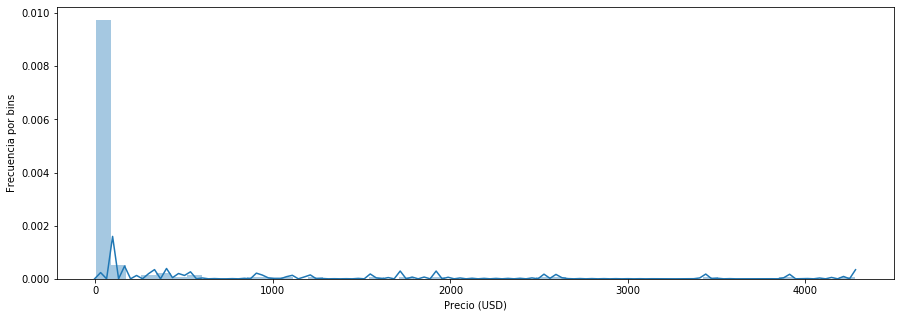

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(data_games.price.value_counts())
ax.set_xlabel('Precio (USD)')
ax.set_ylabel('Frecuencia por bins')

#### Observamos un sesgo respecto a la distribución de los precios de los juegos, donde la mayoría se encuentra entre 0 y los 30 USD, lo cual es normal para juegos de PC.

Text(0, 0.5, 'Frecuencia por bins')

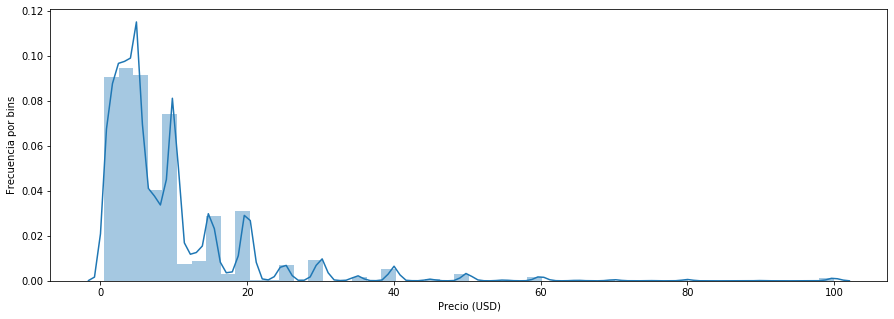

In [5]:
# Excluiremos para este gráfico los valores con caracteres no numéricos para explorar los precios de los juegos

data_games2 = data_games.drop(data_games[(data_games.price == 'Free To Play') |
                                         (data_games.price == 'Free to Play') |
                                        (data_games.price == 'Free') |
                                        (data_games.price == 'Free Demo') |
                                        (data_games.price == 'Play for Free!') |
                                        (data_games.price == 'Install Now') |
                                        (data_games.price == 'Play WARMACHINE: Tactics Demo') |
                                        (data_games.price == 'Free Mod') |
                                        (data_games.price == 'Install Theme') |
                                        (data_games.price == 'Third-party') |
                                        (data_games.price == 'Play Now') |
                                        (data_games.price == 'Free HITMAN™ Holiday Pack') |
                                        (data_games.price == 'Play the Demo') |
                                        (data_games.price == 'Starting at $499.00')|
                                        (data_games.price == 'Starting at $449.00') |
                                        (data_games.price == 'Free to Try') |
                                        (data_games.price == 'Free Movie') |
                                        (data_games.price == 'Free To Use') |
                                        (data_games.price == 'Free to Use')].index)

data_games2 = data_games2[data_games2.price<=100]
fig, ax = plt.subplots(figsize=(15,5))
ax = sns.distplot(data_games2.price)
ax.set_xlabel('Precio (USD)')
ax.set_ylabel('Frecuencia por bins')

#### Para entender cuales son los juegos más relevantes según los usuarios que realizaron reviewas, haremos un match de los 100 juegos con mas reviews del dataset, tal que tengan mas de 5 horas acumuladas de uso del juego por usuario

In [6]:
import time

match = pd.DataFrame(columns=['publisher','genres','app_name','title','total_hours_played','url','release_date','tags','discount_price','reviews_url','specs','price','early_access','id','developer','sentiment','metascore']  )
#for i in range(1,len(data_reviews)):
for i in range(0,100):
    print(i, end="\r")
    time.sleep(0.1)
    match_id=data_reviews[data_reviews.hours > 5].product_id.value_counts().index[i]
    match=match.append(data_games[data_games.id==match_id])
    match['total_hours_played'].iloc[i]=data_reviews[data_reviews.product_id == str(match_id)].product_id.astype(int).sum()

match.head(3)

,publisher,genres,app_name,title,total_hours_played,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31856,Valve,"[Action, Free to Play]",Team Fortress 2,Team Fortress 2,11502040,http://store.steampowered.com/app/440/Team_For...,2007-10-10,"[Free to Play, Multiplayer, FPS, Action, Shoot...",NaN,http://steamcommunity.com/app/440/reviews/?bro...,"[Multi-player, Cross-Platform Multiplayer, Ste...",Free to Play,False,440,Valve,Very Positive,92
29692,Facepunch Studios,"[Action, Adventure, Indie, Massively Multiplay...",Rust,Rust,3696958580,http://store.steampowered.com/app/252490/Rust/,2013-12-11,"[Early Access, Survival, Crafting, Multiplayer...",NaN,http://steamcommunity.com/app/252490/reviews/?...,"[Multi-player, MMO, Cross-Platform Multiplayer...",19.99,True,252490,Facepunch Studios,Very Positive,NaN
30746,"2K Games, Aspyr (Mac &amp;amp; Linux)","[Action, RPG]",Borderlands 2,Borderlands 2,513918560,http://store.steampowered.com/app/49520/Border...,2012-09-17,"[FPS, Co-op, Action, RPG, Loot, Shooter, Open ...",NaN,http://steamcommunity.com/app/49520/reviews/?b...,"[Single-player, Co-op, Steam Achievements, Ful...",19.99,False,49520,"Gearbox Software,Aspyr (Mac &amp; Linux)",Overwhelmingly Positive,89


### ¿Cuántos usuarios únicos hay?

In [7]:
len(data_reviews.user_id)

1113296

### ¿Cuántos juegos calificó cada usuario?

In [8]:
data_reviews.username.value_counts()

123             304
Alex            249
Nick            218
Chris           189
..              182
               ... 
Billynomates      1
Aries403          1
enaecore          1
DOKKAEBI          1
Touss             1
Name: username, Length: 713170, dtype: int64

### ¿cuáles son los juegos más populares?¿Y los menos populares?

In [9]:
# Los 10 más populares
for i in range(0,9):
    print(data_games[data_games.id==str(data_reviews.product_id.value_counts().index[i])].title.values)

['Team Fortress 2']
['Rust']
['Borderlands 2']
['Fallout 4']
['Grand Theft Auto V']
['Undertale']
['Portal 2']
['DayZ']
['Warframe']


In [10]:
# Los 10 menos populares
for i in range(0,9):
    print(data_games[data_games.id==str(data_reviews.product_id.value_counts(ascending=True).index[i])].title.values)

['Boom Box Blue!']
['Naruto the Movie: Guardians of the Crescent Moon Kingdom']
['aMaze Achievements : forest']
['City of Ages: Picture Supportive Text MUD (server and client included)']
['Massive Assault']
['Achievement Hunter: Thief']
['Battle Of Europe']
['Hostil']
['GameMaker Studio 2 Mobile']


#### Eliminaremos los valores faltantes de user_id, product_id y metascore, debido a que sin ellos no podremos entrenar el modelo. No los sustituiremos ya que contamos con suficiente información como para que los faltantes no afecten.

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### ¿Cuantos valores faltantes realmente existen en los features product_id, user_id y metascore?

In [12]:
data_reviews.product_id.isna().sum()

0

In [13]:
data_reviews.user_id.isna().sum()

660348

In [14]:
data_reviews.product_id = data_reviews.product_id.replace(['NA'],np.nan)
data_reviews = data_reviews[~data_reviews.product_id.isna()]
data_reviews = data_reviews[~data_reviews.user_id.isna()]
data_reviews.shape

(452948, 12)

### ¿Cómo es la distribución de las calificaciones y horas jugadas?

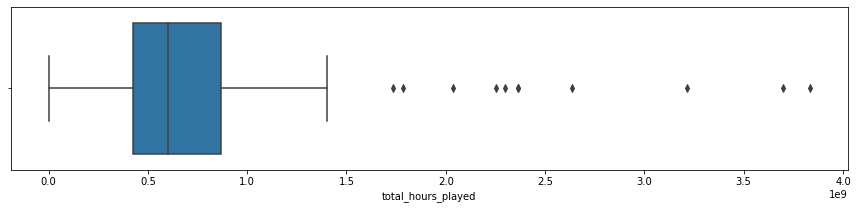

In [15]:
# Gráfico de horas jugadas en el top 100 de juegos (dataset match)

plt.subplots(figsize=(15,3))
#sns.boxplot(x=match['total_hours_played'])
sns.boxplot(x=match['total_hours_played'])

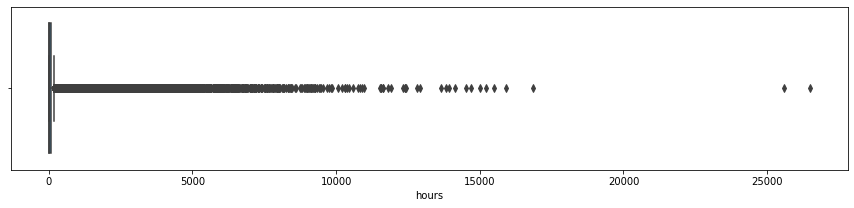

In [16]:
#Gráfico de horas jugadas por usuario por juego

plt.subplots(figsize=(15,3))
sns.boxplot(x=data_reviews[~data_reviews['hours'].isna()]['hours'])

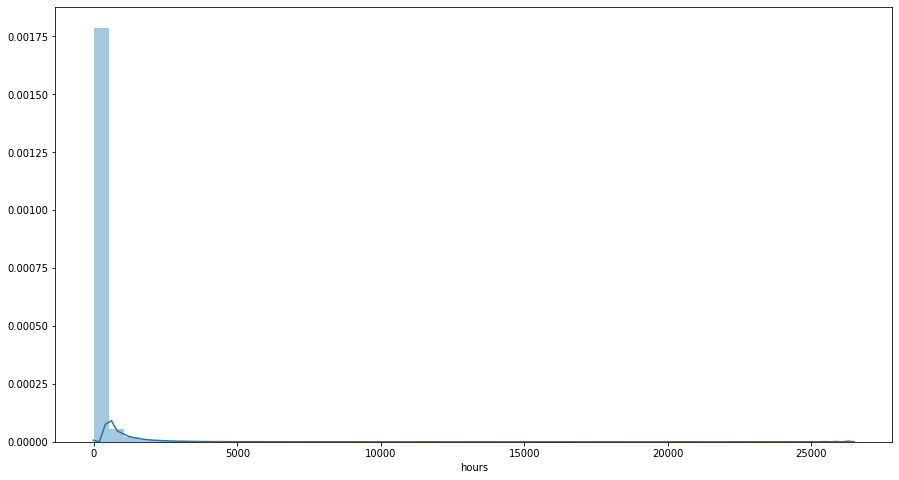

In [17]:
plt.subplots(figsize=(15,8))
sns.distplot(data_reviews[~data_reviews['hours'].isna()]['hours'])

#### Existen juegos y usuarios con cantidades de horas jugadas que pueden considerarse como outliers, las cuales eliminaremos.

In [18]:
valor_medio = data_reviews['hours'].mean()
std = data_reviews['hours'].std()
minimo = valor_medio - 3*std
maximo = valor_medio + 3*std
mascara_outliers = np.logical_or(data_reviews['hours'] < minimo, data_reviews['hours'] > maximo)
print(valor_medio, std, minimo, maximo)

121.26549068384124 390.46328053736795 -1050.1243509282624 1292.655332295945


In [19]:
mascara_outliers.value_counts()

False    445375
True       7573
Name: hours, dtype: int64

In [20]:
data_reviews = data_reviews[~mascara_outliers]
data_reviews['hours'].describe()

count    444276.000000
mean         82.877335
std         174.037405
min           0.000000
25%           4.600000
50%          17.900000
75%          68.100000
max        1292.500000
Name: hours, dtype: float64

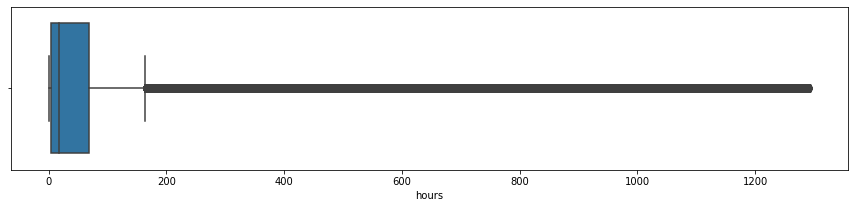

In [21]:
plt.subplots(figsize=(15,3))
sns.boxplot(x=data_reviews[~data_reviews['hours'].isna()]['hours'])

### Filtraremos los juegos jugados por más de 2 usuarios y por mas de 20 horas por usuario

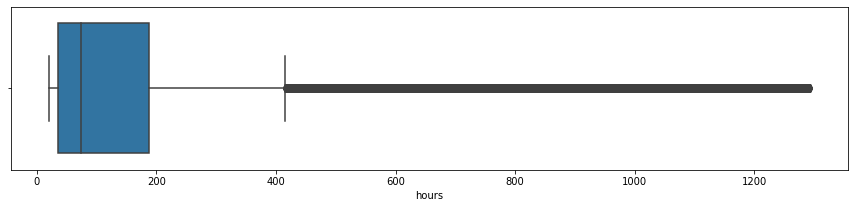

In [22]:
data_reviews = data_reviews[data_reviews['hours'] >= 20]
plt.subplots(figsize=(15,3))
sns.boxplot(x=data_reviews[~data_reviews['hours'].isna()]['hours'])

In [23]:
data_reviews.user_id.value_counts()

76561197969749884    93
76561198011965365    23
76561198010131631    16
76561198010800766    15
76561198014906902    12
                     ..
76561198120807779     1
76561198271905399     1
76561198059976589     1
76561198008372754     1
76561198054990839     1
Name: user_id, Length: 186853, dtype: int64

### Eliminaremos los juegos con pocos reviews (menos de 2)

In [24]:
print(data_reviews.shape)
data_reviews = data_reviews.groupby('user_id').filter(lambda x: len(x) >= 2)
data_reviews.user_id.value_counts()
print(data_reviews.shape)

(212142, 12)
(44957, 12)


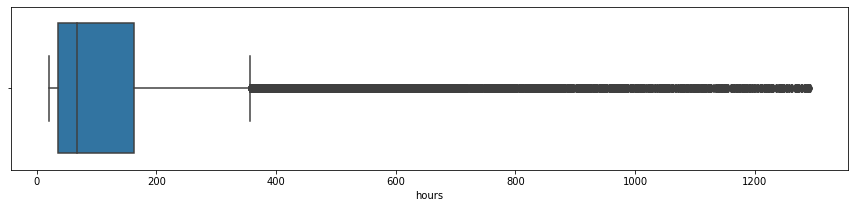

In [25]:
plt.subplots(figsize=(15,3))
sns.boxplot(x=data_reviews[~data_reviews['hours'].isna()]['hours'])

### ¿Cuál es el juego con más reviews?

In [26]:
match.iloc[0]

publisher                                                         Valve
genres                                           [Action, Free to Play]
app_name                                                Team Fortress 2
title                                                   Team Fortress 2
total_hours_played                                             11502040
url                   http://store.steampowered.com/app/440/Team_For...
release_date                                                 2007-10-10
tags                  [Free to Play, Multiplayer, FPS, Action, Shoot...
discount_price                                                      NaN
reviews_url           http://steamcommunity.com/app/440/reviews/?bro...
specs                 [Multi-player, Cross-Platform Multiplayer, Ste...
price                                                      Free to Play
early_access                                                      False
id                                                              

### Ordenamos los juegos por popularidad

In [27]:
match.head()

,publisher,genres,app_name,title,total_hours_played,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31856,Valve,"[Action, Free to Play]",Team Fortress 2,Team Fortress 2,11502040,http://store.steampowered.com/app/440/Team_For...,2007-10-10,"[Free to Play, Multiplayer, FPS, Action, Shoot...",NaN,http://steamcommunity.com/app/440/reviews/?bro...,"[Multi-player, Cross-Platform Multiplayer, Ste...",Free to Play,False,440,Valve,Very Positive,92
29692,Facepunch Studios,"[Action, Adventure, Indie, Massively Multiplay...",Rust,Rust,3696958580,http://store.steampowered.com/app/252490/Rust/,2013-12-11,"[Early Access, Survival, Crafting, Multiplayer...",NaN,http://steamcommunity.com/app/252490/reviews/?...,"[Multi-player, MMO, Cross-Platform Multiplayer...",19.99,True,252490,Facepunch Studios,Very Positive,NaN
30746,"2K Games, Aspyr (Mac &amp;amp; Linux)","[Action, RPG]",Borderlands 2,Borderlands 2,513918560,http://store.steampowered.com/app/49520/Border...,2012-09-17,"[FPS, Co-op, Action, RPG, Loot, Shooter, Open ...",NaN,http://steamcommunity.com/app/49520/reviews/?b...,"[Single-player, Co-op, Steam Achievements, Ful...",19.99,False,49520,"Gearbox Software,Aspyr (Mac &amp; Linux)",Overwhelmingly Positive,89
25017,Bethesda Softworks,[RPG],Fallout 4,Fallout 4,3832322760,http://store.steampowered.com/app/377160/Fallo...,2015-11-09,"[Open World, Post-apocalyptic, Exploration, Si...",NaN,http://steamcommunity.com/app/377160/reviews/?...,"[Single-player, Steam Achievements, Full contr...",29.99,False,377160,Bethesda Game Studios,Mixed,84
26955,Rockstar Games,"[Action, Adventure]",Grand Theft Auto V,Grand Theft Auto V,2299824120,http://store.steampowered.com/app/271590/Grand...,2015-04-14,"[Open World, Action, Multiplayer, First-Person...",NaN,http://steamcommunity.com/app/271590/reviews/?...,"[Single-player, Multi-player, Steam Achievemen...",39.99,False,271590,Rockstar North,Mixed,96


In [28]:
data_games = data_games.rename(columns={'id':'product_id'})
data_reviews = data_reviews.merge(data_games, on='product_id', how='left')

# Transformaremos los tipos de datos
data_reviews.metascore = data_reviews.metascore.replace(['NA'],np.nan)
data_reviews.metascore = data_reviews.metascore.astype(np.float32)
data_reviews.product_id = data_reviews.product_id.astype(int) 

data_reviews.metascore.value_counts()

84.0    2571
81.0    2122
88.0    1879
89.0    1840
92.0    1715
        ... 
48.0       2
27.0       1
20.0       1
50.0       1
24.0       1
Name: metascore, Length: 61, dtype: int64

In [29]:
# Eliminaremos los valores faltatentes

print(data_reviews.shape)
data_reviews = data_reviews[~data_reviews.metascore.isna()]
print(data_reviews.shape)

(44987, 27)
(31035, 27)


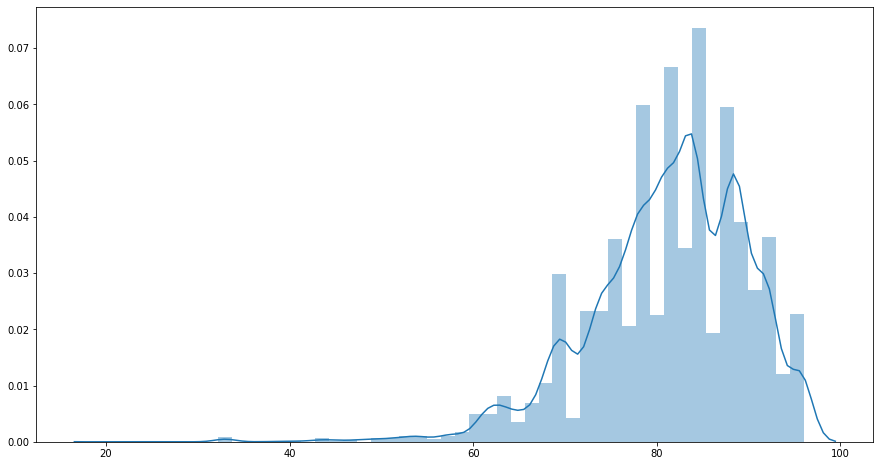

In [30]:
plt.subplots(figsize=(15,8))
sns.distplot(data_reviews.metascore.astype(int).values)

#### Observando el nivel de sesgo en la distribución de metascores, filtraremos nuestro dataset a solo las reviews y juegos con metascore mayor a 55.0

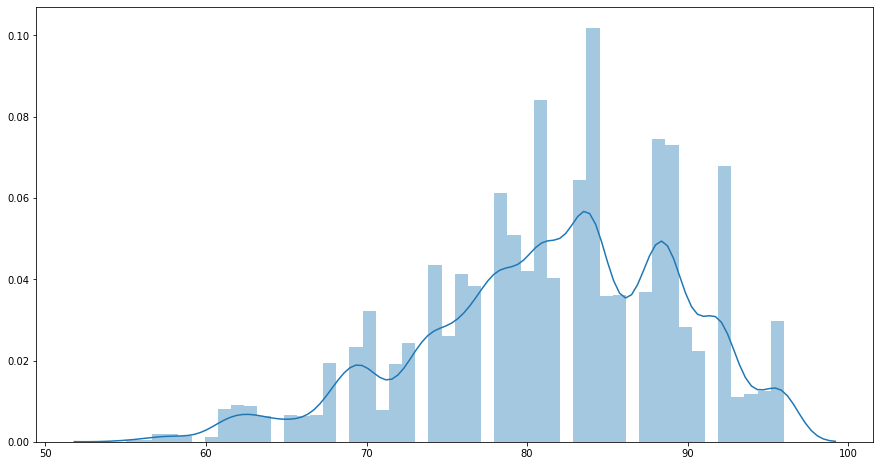

In [31]:
data_reviews = data_reviews[data_reviews.metascore >= 55]
plt.subplots(figsize=(15,8))
sns.distplot(data_reviews.metascore.astype(int).values)

In [32]:
data_reviews = data_reviews.drop(columns=['products','page_order','date','text','early_access_x','page','found_funny','compensation','publisher','app_name','url','release_date','tags','discount_price','reviews_url','specs','early_access_y','developer','sentiment'])
data_reviews.head(2)

,username,hours,product_id,user_id,genres,title,price,metascore
0,Kevin Droid,21.6,35140,76561198030870442,"[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,19.99,91.0
3,tung.tungnguyen trade.tf,114.8,271590,76561198211759421,"[Action, Adventure]",Grand Theft Auto V,39.99,96.0


In [33]:
data_reviews.to_csv('data_reviews 24 12 2020.csv', sep=',')

In [34]:
data_games = data_games[~data_games.product_id.isna()]
data_games.product_id = data_games.product_id.astype(int)

# Entrenamiento de modelos de sistema de recomendación

Para entrenar el sistema de recomendación vamos a usar la biblioteca Surprise. Recomendamos tener abierta la [documentación](https://surprise.readthedocs.io/en/stable/getting_started.html) a medida que van a través de este notebook.

El objetivo del entrenamiento del modelo es desarrollar un algoritmo que pueda predecir el feature target (usualmente relacionado con el rating o calificación de satisfacción según usuarios) para usuarios e items (juegos) que no tengan un rating asignado a su respectiva combinación.

### Eligiremos como target el feature metascore, ya que es proporcional al rating de satisfacción de cada juego

In [35]:
!pip install surprise

from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV

# Parametrizamos el modelo para que el rating o metascore se interprete como una cantidad que puede variar entre 1 y 100.

reader = Reader(rating_scale=(1, 100))

df1 = data_reviews.copy()
df1 = df1.drop(['metascore','genres','title','title','price'], axis=1)
df1.head(2)

,username,hours,product_id,user_id
0,Kevin Droid,21.6,35140,76561198030870442
3,tung.tungnguyen trade.tf,114.8,271590,76561198211759421


In [36]:
data_games_train = data_games.copy()
df1= pd.merge(df1, data_games_train, on='product_id', how='inner')
df1['user_id'] = df1['user_id'].dropna()
df1 = df1[~df1['user_id'].isnull()]
df1 = df1[df1['metascore']!='NA']
df1.head(2)

,username,hours,product_id,user_id,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,developer,sentiment,metascore
0,Kevin Droid,21.6,35140,76561198030870442,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91
1,Fugitive Mind,20.7,35140,76561198105445916,"Warner Bros. Interactive Entertainment, Feral ...","[Action, Adventure]",Batman: Arkham Asylum Game of the Year Edition,Batman: Arkham Asylum Game of the Year Edition,http://store.steampowered.com/app/35140/Batman...,2010-03-26,"[Action, Batman, Stealth, Adventure, Third Per...",NaN,http://steamcommunity.com/app/35140/reviews/?b...,"[Single-player, Steam Achievements, Steam Trad...",19.99,False,"Rocksteady Studios,Feral Interactive (Mac)",Overwhelmingly Positive,91


In [37]:
# Cargamos los datos según indica la librería Surprise, en el dataset "data"

data = Dataset.load_from_df(df1[['user_id', 'product_id', 'metascore']], reader)
data

In [38]:
# Realizamos una separación de train y test del 25%

trainset, testset = train_test_split(data, test_size=.25)
print(trainset)

### Empezaremos por entrenar el primer modelo (SVD) sin parametrizar

Entrenaremos sin especificar parámetros un modelo de recomendación basado en el algoritmo de descomposición en valores singulares (SVD). Este modelo no puede usarse para el enfoque como filtro colaborativo pero nos servirá como benchmark.

In [39]:
from surprise import SVD
algo = SVD()
algo.fit(trainset)

In [40]:
predictions = algo.test(testset)
predictions[0]

Prediction(uid='76561198192931842', iid=211820, r_ui=81.0, est=81.04393013645638, details={'was_impossible': False})

## ¿Que significa esta predicción?

El dataset "predictions" contiene TODAS las predicciones para cada uno de los usuarios (user_id o uid) y desde ellos, para cada uno de los juegos (product_id o iid), en donde el rating real del juego fue 85.0 (metascore o r_ui) y el estimado según el algoritmo de SVD es de 84.65.

In [41]:
df1[['user_id', 'product_id', 'hours']][df1['user_id']=='76561198135446411']

,user_id,product_id,hours
13514,76561198135446411,208580,449.5


### Usuarios con mayor cantidad de reviews

In [42]:
data_reviews.user_id.value_counts()

76561197969749884    56
76561198010800766    13
76561198011965365    11
76561198010131631    10
76561198043627942    10
                     ..
76561198027265213     1
76561198289930181     1
76561198020870372     1
76561197976794215     1
76561198095408505     1
Name: user_id, Length: 16763, dtype: int64

In [43]:
data_reviews[data_reviews.user_id=='76561197969749884'].head(3) #Es el user_id con mayor cantidad de reviews realizadas

,username,hours,product_id,user_id,genres,title,price,metascore
177,Sarkoth,53.9,234710,76561197969749884,"[Casual, Sports]",Poker Night 2,4.99,75.0
284,Sarkoth,67.4,308420,76561197969749884,"[Action, Indie, RPG]",Ziggurat,14.99,75.0
962,Sarkoth,49.2,204530,76561197969749884,"[Action, Indie, Strategy]",Infested Planet,14.99,75.0


In [44]:
data_games[data_games.product_id==234710] #Es uno de los juegos que 76561197969749884 hizo review

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,product_id,developer,sentiment,metascore
1362,Telltale Games,"[Casual, Sports]",Poker Night 2,Poker Night 2,http://store.steampowered.com/app/234710/Poker...,2013-04-26,"[Casual, Card Game, Comedy, Singleplayer, Gamb...",NaN,http://steamcommunity.com/app/234710/reviews/?...,"[Single-player, Full controller support]",4.99,False,234710,Telltale Games,Very Positive,75


In [45]:
algo.predict(76561197969749884,234710)

Prediction(uid=76561197969749884, iid=234710, r_ui=None, est=81.48699256010944, details={'was_impossible': False})

### La predicción anterior significa que para el usuario de id "76561197969749884" y el juego "234710" el modelo predice un metascore (rating) de "81.44/100"

Esto en realidad es un problema ya que como comprobamos en la celda anterior, el metascore real fue mucho menor, en 75.0 de metascore

Exploremos un usuario, veamos cuáles juegos le gustaron y cuáles les recomienda el sistema.

Juegos que le gustaron

In [46]:
usuario = '76561197969749884'
df_user = df1[(df1['user_id'] == usuario) & (df1['metascore'] >= 70.0)]
df_user = df_user.reset_index(drop=True)
df_user.metascore.describe()

count     44
unique    19
top       75
freq       6
Name: metascore, dtype: int64

Creamos un dataframe en donde vamos a guardar las recomendaciones

In [47]:
recomendaciones_usuario = data_games[['title','product_id']].iloc[:4499].copy()
recomendaciones_usuario.index = recomendaciones_usuario.product_id
recomendaciones_usuario = recomendaciones_usuario.drop(['product_id'], axis=1)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,NaN


In [48]:
usuario_vistas = df1[['user_id', 'product_id', 'metascore']][df1['user_id'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(56, 3)


,user_id,product_id,metascore
762,76561197969749884,234710,75
896,76561197969749884,308420,75
1660,76561197969749884,204530,75
1876,76561197969749884,214340,74
2091,76561197969749884,18120,73


In [49]:
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,NaN


Y hacemos las recomendaciones

In [50]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,product_id,title,Estimate_Score
188,22000,World of Goo,90.500052
556,12120,Grand Theft Auto: San Andreas,89.985235
98,4760,Rome: Total War™ - Collection,89.584914
95,7670,BioShock™,89.470116
631,620,Portal 2,89.470089
252,22330,The Elder Scrolls IV: Oblivion® Game of the Ye...,89.380197
253,22320,The Elder Scrolls III: Morrowind® Game of the ...,89.078064
28,70,Half-Life,88.691381
4366,391540,Undertale,87.374998
2653,240760,Wasteland 2: Director's Cut,86.958400


In [51]:
recomendaciones_usuario.shape

(4499, 3)

#### Si bien las recomendaciones se efectuaron basadas en juegos de alto metascore, ninguno de los juegos coincide con los que jugó el usuario en realidad. Esto es un problema.

###  Evaluación usando métrica RMSE

Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones.

RMSE es solo la raíz cuadrada de MSE. La raíz cuadrada se introduce para hacer que la escala de los errores sea igual a la escala de los objetivos.

Usaremos RMSE ya que al tomar la raíz cuadrada de MSE, aumentamos la sensibilidad a errores consdierados como outliers.

In [52]:
from surprise import accuracy

rmse_svd_1 = accuracy.rmse(predictions)

accuracy.rmse(predictions)

RMSE: 3.1471
RMSE: 3.1471


3.1471406993814504

### Optimización de parámetros, segundo modelo (SVD)

In [53]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.8101  2.7212  2.6402  2.7238  0.0694  
Fit time          0.30    0.30    0.31    0.30    0.00    
Test time         0.06    0.06    0.07    0.06    0.00    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.7230  2.7420  2.7500  2.7383  0.0113  
Fit time          0.31    0.30    0.32    0.31    0.01    
Test time         0.06    0.06    0.06    0.06    0.00    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.6587  2.8156  2.8295  2.7679  0.0775  
Fit time          0.33    0.31    0.32    0.32    0.01    
Test time         0.07    0.13    0.06    0.09    0.03    
8
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.9261  2.6

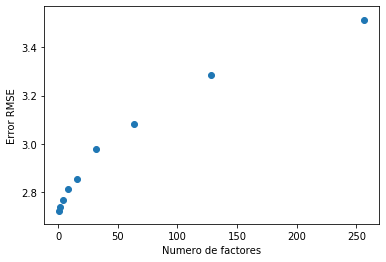

In [54]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

In [55]:
from surprise.model_selection import GridSearchCV

param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

In [56]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

2.7579721822809127
{'n_factors': 5, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.002}


In [57]:
rmse_test_means = []
factores = [1,2,4,5,8,16,32,64,128,256]

for factor in factores:
    print(factor)
    algo = SVD(n_factors=factor, n_epochs=20, lr_all=0.005, reg_all=0.002)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))

1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.6312  2.7814  2.7029  2.7052  0.0613  
Fit time          0.30    0.28    0.29    0.29    0.01    
Test time         0.06    0.06    0.06    0.06    0.00    
2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.6815  2.6979  2.7720  2.7171  0.0393  
Fit time          0.30    0.29    0.30    0.30    0.00    
Test time         0.06    0.06    0.12    0.08    0.03    
4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.7698  2.6750  2.7903  2.7450  0.0502  
Fit time          0.32    0.31    0.32    0.32    0.01    
Test time         0.06    0.06    0.06    0.06    0.00    
5
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    2.8756  2.6

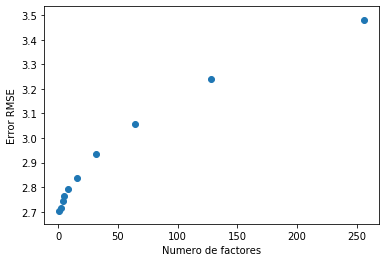

In [58]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()

### Con estos parámetros, reentrenaremos un tercer modelo (SVD) y mediremos las recomendaciones:

In [59]:
reader = Reader(rating_scale=(1, 100))
data = Dataset.load_from_df(df1[['user_id', 'product_id', 'metascore']], reader)
trainset, testset = train_test_split(data, test_size=.25)
algo = SVD(n_factors=5, n_epochs=20, lr_all=0.005, reg_all=0.002)
algo.fit(trainset)
predictions = algo.test(testset)

In [60]:
usuario = 76561198011965365
df_user = df1[(df1['user_id'] == usuario) & (df1['metascore'] >= 70.0)]
df_user = df_user.reset_index(drop=True)

recomendaciones_usuario = data_games[['title','product_id']].iloc[:4499].copy()
recomendaciones_usuario.index = recomendaciones_usuario.product_id
recomendaciones_usuario = recomendaciones_usuario.drop(['product_id'], axis=1)
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(4499, 1)


,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,弹炸人2222
773570,NaN


In [61]:
usuario_vistas = df1[['user_id', 'product_id', 'metascore']][df1['user_id'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(0, 3)


,user_id,product_id,metascore


In [62]:
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,773570,NaN


In [63]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
recomendaciones_usuario.head(10)

,product_id,title,Estimate_Score
28,70,Half-Life,95.120082
631,620,Portal 2,94.939495
95,7670,BioShock™,94.852909
252,22330,The Elder Scrolls IV: Oblivion® Game of the Ye...,93.779822
556,12120,Grand Theft Auto: San Andreas,92.155700
4366,391540,Undertale,91.941863
98,4760,Rome: Total War™ - Collection,91.479342
1672,238010,Deus Ex: Human Revolution - Director's Cut,90.886490
358,22370,Fallout 3: Game of the Year Edition,90.673085
493,8930,Sid Meier's Civilization® V,89.989729


In [64]:
match=pd.DataFrame()
for i in range(0,len(data_reviews[data_reviews.user_id=='76561198011965365'])):
    match=match.append(data_games[data_games.product_id==data_reviews[data_reviews.user_id=='76561198011965365'].product_id.values[i]])
match[['product_id','title','metascore','tags']].head()

,product_id,title,metascore,tags
751,45770,Dead Rising 2: Off the Record,66,"[Action, Zombies, Adventure, Open World, Onlin..."
204,9480,Saints Row 2,72,"[Open World, Action, Sandbox, Character Custom..."
723,63940,Men of War: Vietnam,68,"[Strategy, RTS, War, Tactical, Real Time Tacti..."
31771,17460,Mass Effect,89,"[RPG, Sci-fi, Story Rich, Action, Third-Person..."
31095,105450,Age of Empires® III: Complete Collection,81,"[Strategy, RTS, Base Building, Historical, Mul..."


In [65]:
rmse_svd_3 = accuracy.rmse(predictions)

accuracy.rmse(predictions)

RMSE: 2.7395
RMSE: 2.7395


2.7394998298325715

### Ahora aplicaremos el concepto de Filtro Colaborativo y observaremos la mejora en el performace del modelo

https://pankaj-tiwari2.medium.com/neighborhood-based-collaborative-filtering-in-python-using-surprise-fe9d5700cb58

#### Crearemos un anti_set, que consiste de los pares de usuarios y juegos que no existen en el dataset original. Este es el set en el cual desemos predecir los metascores.

In [66]:
data_final = data_reviews[['user_id', 'product_id', 'metascore']][:100000]
reader = Reader(rating_scale=(1, 100))
# The columns must correspond to user id, item id and metascores (in that order).
data = Dataset.load_from_df(data_final, reader)
anti_set = data.build_full_trainset().build_anti_testset()

#### Lo normal para el antiset es que genere para cada usuario o juego faltante, un metascore promedio correspondiente

In [67]:
games = data_reviews[['product_id' , 'title']].drop_duplicates(['product_id' , 'title'])
users = data_reviews[['user_id' , 'username']].drop_duplicates(['user_id' , 'username'])

#### Usaremos vecinos mas cercanos ya que es compatible con Filtro Colaborativo y similitud de coseno:

In [68]:
kf = KFold(n_splits=3)
algo = KNNBasic()
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_algo = algo
        best_pred = predictions

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 6.8290
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 6.7834
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 6.9562


### Según la referencia que usamos, el RMSE que estamos obteniendo resulta alto. Continuamos generando más modelos y resultados para comparar.

### Entrenaremos un quinto modelo, con otro tipo de KNN

In [69]:
kf = KFold(n_splits=5)
sim_options = {'name':'cosine'}
algo = KNNWithMeans(sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_algo = algo
        best_rmse= rmse
        best_pred = predictions

rmse_knn_1 = best_rmse   
print(best_rmse)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 7.9709
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 8.0232
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 8.0615
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 8.0243
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 7.8697
7.869690917372629


### Usando opciones de similitud de coseno en el algoritmo, entrenaremos un sexto modelo. 

https://gist.github.com/pankajti/e631e8f6ce067fc76dfacedd9e4923ca#file-surprise_knn_recommendation-ipynb

In [70]:
sim_options = {'name': 'cosine' ,'user_based':  False}
kf = KFold(n_splits=5)
algo = KNNWithMeans(k =3 , sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse= rmse
        best_algo = algo
        best_pred = predictions
        
rmse_knn_2 = best_rmse   
print(best_rmse)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 4.5585
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 4.6525
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 4.6196
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 4.7089
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 4.6539
4.558512818783419


### Gridsearch KNN

In [71]:
param_grid = {'n_factors': [3,4,5,50,100],'n_epochs': [3,4,5,10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

8.10097217628874
{'n_factors': 3, 'n_epochs': 3, 'lr_all': 0.001, 'reg_all': 0.002}


In [72]:
param_grid = {'n_factors': [3,4,5,50,100],'n_epochs': [3,4,5,10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

2.993514709607082
{'n_factors': 3, 'n_epochs': 3, 'lr_all': 0.001, 'reg_all': 0.002}


### Usando los parámetros del Gridsearch, entrenaremos un séptimo modelo

In [74]:
# Usar parámetros del gridsearch

sim_options = {'name': 'cosine' ,'user_based':  False}
kf = KFold(n_splits=5)
algo = KNNBaseline(k =3 , sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse= rmse
        best_algo = algo
        best_pred = predictions
        
rmse_knn_3 = best_rmse   
print(best_rmse)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.9201
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.8616
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.9246
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.8998
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.9558
2.861613993759488


### Análisis de predicciones para datos conocidos

In [75]:
pred_df = pd.DataFrame(best_pred).merge(data_reviews , left_on = ['uid', 'iid'], right_on = ['user_id', 'product_id'])
pred_df[['uid', 'iid',  'username', 'user_id', 'title', 'product_id', 'est','metascore']]

,uid,iid,username,user_id,title,product_id,est,metascore
0,76561198060870160,402570,Mr.Tonguesoff(Mr Krabs Unfair),76561198060870160,Atlas Reactor,402570,81.237792,81.0
1,76561198118240131,377160,Chris,76561198118240131,Fallout 4,377160,83.980253,84.0
2,76561198030665293,214490,Scuzzlebutt,76561198030665293,Alien: Isolation,214490,81.200299,81.0
3,76561198135702357,551730,Cenosys,76561198135702357,Toukiden 2,551730,78.866629,73.0
4,76561198171411650,440,The critpotato,76561198171411650,Team Fortress 2,440,92.000000,92.0
...,...,...,...,...,...,...,...,...
7579,76561197972483399,228260,Hamburger! N00BS welcome!,76561197972483399,Fallen Enchantress: Legendary Heroes,228260,80.144038,80.0
7580,76561198032943558,367520,frosty0993,76561198032943558,Hollow Knight,367520,85.448481,86.0
7581,76561198003340520,2820,NoneSmith,76561198003340520,X3: Terran Conflict,2820,76.887630,73.0
7582,76561197998928520,8930,bump,76561197998928520,Sid Meier's Civilization® V,8930,89.923293,90.0


### Análisis de predicciones para datos desconocidos

In [76]:
anti_pre = best_algo.test(anti_set)
pred_df = pd.DataFrame(anti_pre).merge(games , left_on = ['iid'], right_on = ['product_id'])
pred_df = pd.DataFrame(pred_df).merge(users , left_on = ['uid'], right_on = ['user_id'])

In [77]:
pred_df[(pred_df['est']>70.0)&(pred_df['user_id']=='76561198353396844')].head()

,uid,iid,r_ui,est,details,product_id,title,user_id,username
14408751,76561198353396844,271590,81.576704,95.707413,"{'actual_k': 0, 'was_impossible': False}",271590,Grand Theft Auto V,76561198353396844,the_maker988
14408752,76561198353396844,452570,81.576704,81.546219,"{'actual_k': 0, 'was_impossible': False}",452570,Battle Chef Brigade,76561198353396844,the_maker988
14408753,76561198353396844,8880,81.576704,82.997028,"{'actual_k': 0, 'was_impossible': False}",8880,Freedom Force,76561198353396844,the_maker988
14408754,76561198353396844,61700,81.576704,80.451879,"{'actual_k': 0, 'was_impossible': False}",61700,Might &amp; Magic: Clash of Heroes,76561198353396844,the_maker988
14408755,76561198353396844,214560,81.576704,88.079112,"{'actual_k': 0, 'was_impossible': False}",214560,Mark of the Ninja,76561198353396844,the_maker988


In [78]:
pred_df['user_id'].value_counts()

76561198029584543    2582
76561198075765938    2582
76561198240638652    2582
76561198097138610    2582
76561198119627604    2582
                     ... 
76561198010131631    1283
76561198043627942    1283
76561198011965365    1282
76561198010800766    1280
76561197969749884    1238
Name: user_id, Length: 16763, dtype: int64

In [79]:
pred_df['username'].value_counts().unique()

array([9041, 9040, 6459, 6457, 5167, 5166, 5165, 5164, 5163, 3876, 3875,
       3874, 3873, 3872, 2584, 2583, 2582, 2581, 2580, 2579, 1292, 1291,
       1290, 1289, 1288, 1287, 1286, 1285, 1284, 1283, 1282, 1280, 1238],
      dtype=int64)

In [80]:
pred_df[(pred_df['est']>70.0)&(pred_df['user_id']=='76561197990406921')].head()

,uid,iid,r_ui,est,details,product_id,title,user_id,username
169027,76561197990406921,271590,81.576704,95.242943,"{'actual_k': 0, 'was_impossible': False}",271590,Grand Theft Auto V,76561197990406921,MMG Man
169028,76561197990406921,452570,81.576704,81.081749,"{'actual_k': 0, 'was_impossible': False}",452570,Battle Chef Brigade,76561197990406921,MMG Man
169029,76561197990406921,8880,81.576704,82.532558,"{'actual_k': 0, 'was_impossible': False}",8880,Freedom Force,76561197990406921,MMG Man
169030,76561197990406921,61700,81.576704,79.987409,"{'actual_k': 0, 'was_impossible': False}",61700,Might &amp; Magic: Clash of Heroes,76561197990406921,MMG Man
169031,76561197990406921,214560,81.576704,87.614643,"{'actual_k': 0, 'was_impossible': False}",214560,Mark of the Ninja,76561197990406921,MMG Man


In [81]:
#pred_df.to_csv('pred_df 19 12 2020.csv', sep=',')

### Encontrando los vecinos más cercanos de un juego

In [82]:
data_games[data_games.product_id=='440'].head(3)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,product_id,developer,sentiment,metascore


In [83]:
tsr_inner_id = best_algo.trainset.to_inner_iid(440)
tsr_neighbors = best_algo.get_neighbors(tsr_inner_id, k=4)
games[games.product_id.isin([algo.trainset.to_raw_iid(inner_id)
                       for inner_id in tsr_neighbors])]

,product_id,title
10602,377160,Fallout 4
16702,333930,Dirty Bomb®
19657,107410,Arma 3
27208,22330,The Elder Scrolls IV: Oblivion® Game of the Ye...


In [84]:
data_reviews.nlargest(3, 'metascore')

,username,hours,product_id,user_id,genres,title,price,metascore
3,tung.tungnguyen trade.tf,114.8,271590,76561198211759421,"[Action, Adventure]",Grand Theft Auto V,39.99,96.0
17,philmont,111.7,271590,76561197977483812,"[Action, Adventure]",Grand Theft Auto V,39.99,96.0
32,Moebius Teras,35.5,271590,76561198020718137,"[Action, Adventure]",Grand Theft Auto V,39.99,96.0


### Comparando resultados de SVD con KNN, de forma gráfica

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

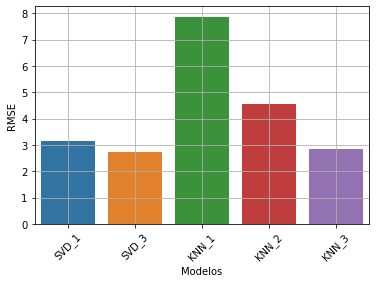

In [85]:
errores = {
    'Modelos': ['SVD_1', 'SVD_3', 'KNN_1', 'KNN_2', 'KNN_3'],
    
    'RMSE': [rmse_svd_1, rmse_svd_3, rmse_knn_1, 
             rmse_knn_2, rmse_knn_3]}

tabla_errores = pd.DataFrame(errores, columns = ['Modelos', 'RMSE'])

sns.barplot(x = 'Modelos', y = 'RMSE', data = tabla_errores)
plt.grid('y')
plt.xticks(rotation = 45)

### Concluimos que el modelo mas performante y que cumple con filtro colaborativo fue:


KNN_3: KNNBaseline con k =3 y sim_options = {'name': 'cosine' ,'user_based':  False}


### Sin embargo, el modelo más performante sin cumplir con ese criterio fue:

SVD_3: SVD con parámetros n_factors=5, n_epochs=20, lr_all=0.005 y reg_all=0.002.

### Sin embargo, el problema de recomendaciones que no coinciden con los juegos jugados sigue existiendo. Se requiere un procedimiento independiente del metascore para esto. Se detallará al final de esta entrega, en la sección de propuestas.

# Pregunta propuesta:


### ¿como ir más allá del metascore en los features del modelo? ¿como usar las horas jugadas y el tag/género? 


#### R: Filtrar primero el dataset por género/etiqueta, entrenando el modelo con esos datos y luego arrojando una predicción

In [86]:
data_reviews.genres.value_counts().index[0]

['Action']

In [87]:
data_reviews_action = data_reviews.copy()
data_reviews_action.genres = data_reviews_action.genres.astype(str)
data_reviews_action = data_reviews_action[data_reviews_action.genres=="['Action']"]
data_reviews_action.head()

,username,hours,product_id,user_id,genres,title,price,metascore
131,Sigmato,20.9,350280,76561198050352619,['Action'],LawBreakers,29.99,76.0
172,Maverick,25.1,350280,76561198260344758,['Action'],LawBreakers,29.99,76.0
184,The Goatnapper,26.2,350280,76561198027738175,['Action'],LawBreakers,29.99,76.0
193,WizardlyOrca,21.1,350280,76561197995145045,['Action'],LawBreakers,29.99,76.0
198,KickazzJack,27.2,350280,76561197970844460,['Action'],LawBreakers,29.99,76.0


In [88]:
data_final = data_reviews_action[['user_id', 'product_id', 'metascore']]
reader = Reader(rating_scale=(1, 100))
data = Dataset.load_from_df(data_final, reader)
anti_set = data.build_full_trainset().build_anti_testset()

sim_options = {'name': 'cosine' ,'user_based':  False}
kf = KFold(n_splits=5)
algo = KNNBaseline(k =3 , sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse= rmse
        best_algo = algo
        best_pred = predictions
        
rmse_knn_4 = best_rmse   
print(best_rmse)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.0605
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.5924
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 3.0294
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.8455
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 2.8911
2.845529852751018


## Comentarios sobre la predicción final vs la expectativa

Hay limitaciones de Memoria RAM para el procesamiento del dataset. Con 16 GB RAM no fue posible para mi procesar el 100% del dataset de reviews, solo logré procesar el 70%.

Predecir recomendaciones mediante rating sirve para casos muy particulares y no es funcional todo el tiempo. Por ejemplo, si abro por primera vez una web de Ecommerce espero ver los productos mejor calificados, pero luego de filtrar de forma manual o buscar de forma repetitiva en la misma web, espero ver que las recomendaciones cada vez más se ajusten a mis parámetros de búsqueda.

Por lo cual, si bien tenía una expectativa de generar recomendaciones con datasets de comportamiento de búsqueda, en realidad solo podemos hacer recomendaciones basadas en los productos de mejor rating.

Finalmente, creo que quizá sea necesario balancear el hecho que algunos usuarios aportan más datos que otros (califican más juegos, generan mas horas y metascore) mediante la sustracción del metascore medio del usuario de todas las calificaciones del mismo

## Propuestas a probar en la próxima entrega sobre este dataset, agregar un nuevo dataset externo para complementar el modelo

Dataset externo: web actual de Steam https://store.steampowered.com/ obtener nuevas reseñas para testear la predicción, inclusive usando mi cuenta personal de Steam para entender si las recomendaciones se alinean. Usar web scrapping con Selenium y Beautifullsoup.

Usar el texto de dejó el usuario al calificar, para mejorar el sistema de recomendación, usado librerías de procesamiento de lenguaje natural.

Evitar el metascore y generar una métrica numérica de rating de cada review a partir del texto de la calificación. Depender del metascore es depender de una variable calculada por la plataforma y no generada por el usuario (no depende del dataset de revies ya que es un feature del juego).

Considerar de igual manera en la ponderación la variable "found funny" ya que ella define si la calificación fue negativa o positiva

Resultados esperados: Un script de python que genere recomendaciones basado en data más flexible en su origen (scrapping) y más relacionado a la review de cada usuario (texto de la review de cada uno). Esto no implica mejorar el performance del modelo como objetivo, pero si mejorar la adaptabilidad del mismo.